### Introduction

This notebook is an analysis of the Crowdflower labels of 1000 revisions of Wikipedia talk pages by users who have been blocked for personal harassment. This dataset has been cleaned and filtered to remove common administrator messages. These datasets are annotated via crowdflower to measure friendliness, aggressiveness and whether the comment constitutes a personal attack. 

On Crowdflower, each revision is rated 7 times. The raters are given three questions:

1. Is this comment not English or not human readable?
    * Column 'na'
2. How aggressive or friendly is the tone of this comment? 
    * Column 'how_aggressive_or_friendly_is_the_tone_of_this_comment'
    * Ranges from '---' (Very Aggressive) to '+++' (Very Friendly)
3. Does the comment contain a personal attack or harassment? Please mark all that apply:
    * Column 'is_harassment_or_attack'
    * Users can specify that the attack is:
        * Targeted at the recipient of the message (i.e. you suck). ('recipent')
        * Targeted at a third party (i.e. Bob sucks). ('third_party')
        * Being reported or quoted (i.e. Bob said Henri sucks). ('quoting')
        * Another kind of attack or harassment. ('other')
        * This is not an attack or harassment. ('not_attack')
    
Below, we plot histograms of the units by average rating of each of the questions, examine quantiles of answers, and compute inter-annotator agreement.

### Loading packages and data

In [56]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
pd.set_option('display.max_colwidth', 1000)

In [58]:
# Download data from google drive (Respect Eng / Wiki Collab): wikipdia data/v2_annotated
dat = pd.read_csv('../data/exp2_annotated_1k_no_admin_blocked_user_post_sample.csv')

In [59]:
# Remove test questions
dat = dat[dat['_golden'] == False]

In [60]:
# Replace missing data with 'False'
dat = dat.replace(np.nan, False, regex=True)

In [61]:
#Translate the values from 
#how_aggressive_or_friendly_is_the_tone_of_this_comment into numbers
def translate_how_aggressive_to_num(score):
    str_to_num = {'+++ Very Friendly': 3,
                  '++': 2,
                  '+': 1,
                  'Neutral': 0,
                  '-': -1,
                  '--': -2,
                  '--- Very Aggressive (including passive aggression)': -3}
    if score:
        return str_to_num[score]
    else:
        return np.nan

In [62]:
# We reshape the answers for future analysis
dat['aggression_score'] = dat['how_aggressive_or_friendly_is_the_tone_of_this_comment'].apply(translate_how_aggressive_to_num)

In [63]:
def create_column_of_counts(df, col):
    return df.apply(lambda x: col in str(x))

In [64]:
attack_columns = ['not_attack', 'other', 'quoting', 'recipient', 'third_party']

In [65]:
for col in attack_columns:
    dat[col] = create_column_of_counts(dat['is_harassment_or_attack'], col)

In [66]:
def create_column_of_counts_from_nums(df, col):
    return df.apply(lambda x: int(col) == x)

In [67]:
aggressive_columns = ['-3', '-2', '-1', '0', '1', '2', '3']

In [68]:
for col in aggressive_columns:
    dat[col] = create_column_of_counts_from_nums(dat['aggression_score'], col)

In [69]:
dat['not_attack_0'] = 1 - dat['not_attack']
dat['not_attack_1'] = dat['not_attack']

In [71]:
# Group the data
agg_dict = dict.fromkeys(attack_columns, 'mean')
agg_dict.update(dict.fromkeys(aggressive_columns, 'sum'))
agg_dict.update({'clean_diff': 'first', 'na': 'mean', 'aggression_score': 'mean', 
                 '_id':'count', 'not_attack_0':'sum', 'not_attack_1': 'sum'})
grouped_dat = dat.groupby(['rev_id'], as_index=False).agg(agg_dict)

In [73]:
# Get rid of data which the majority thinks is not in English or not readable
grouped_dat = grouped_dat[grouped_dat['na'] < 0.5]

### Plot histogram of average ratings by revision

For each revision, we take the average of all the ratings by level of friendliness/aggressiveness and for each of the answers to Question 3. The histograms of these averages is displayed below.

In [74]:
def hist_comments(df, bins, plot_by, title):
    plt.figure()
    sliced_array = df[[plot_by]]
    weights = np.ones_like(sliced_array)/len(sliced_array)
    sliced_array.plot.hist(bins = bins, legend = False, title = title, weights=weights)
    plt.ylabel('Proportion')
    plt.xlabel('Average Score')

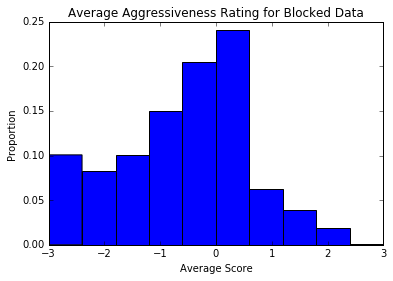

In [75]:
bins = np.linspace(-3,3,11)
hist_comments(grouped_dat, bins, 'aggression_score', 'Average Aggressiveness Rating for Blocked Data')

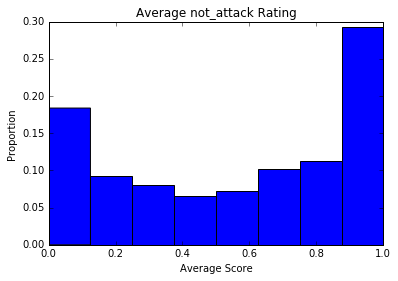

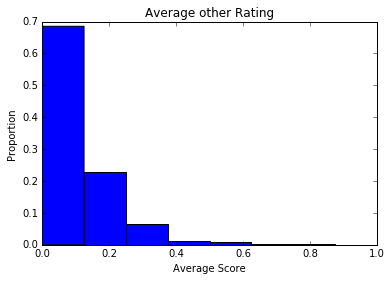

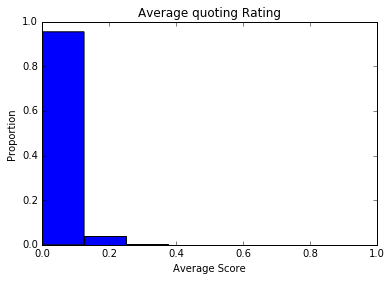

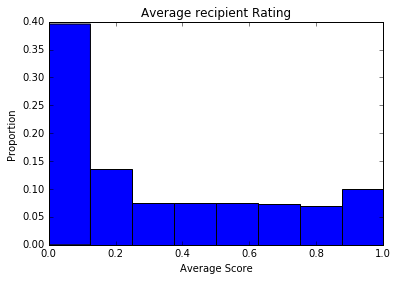

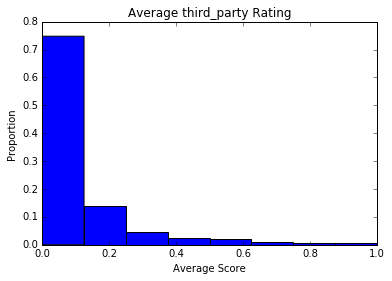

In [76]:
bins = np.linspace(0,1,9)
for col in attack_columns:
    hist_comments(grouped_dat, bins, col, 'Average %s Rating' % col)

### Selected harassing and aggressive revisions by quartile

We look at a sample of revisions whose average aggressive score falls into various quantiles. This allows us to subjectively evaluate the quality of the questions that we are asking on Crowdflower.

In [77]:
def sorted_comments(df, sort_by, quartile, num, is_ascending = True):
    n = df.shape[0]
    start_index = int(quartile*n)
    return df[['clean_diff', 'aggression_score',
              'not_attack', 'other', 'quoting', 'recipient', 'third_party']].sort_values(
        by=sort_by, ascending = is_ascending)[start_index:start_index + num]

In [78]:
# Most aggressive comments
sorted_comments(grouped_dat, 'aggression_score', 0, 5)

clean_diff  \
492                                                                                                                                                         Fucking left-wing bastard \n\nYou left-wing liberalist bastards are enemies of a free and righteous world and ought to be banned!      
737                                                                                                                                                                                                                                 Hum! \n\nFuck you! You are a person worse than pigs or dogs!   
520                                                                                                                                                                                                                                                                  Renzoy16 ! Shut The Fuck Up   
818                                                                                                                                                                                                                                                   su:)ck my ba:)lls you fa:)g:)got \n\nloser   
681   You fascit Nazi! You socialist bastard! You filthy Hippy! \n\nYou dare touch my edits again and I'll go to where you live and kick your ass in person. It shouldn't be hard to find. Communes smell worse than slaughter houses. I make edits. I don't vandilaze. Get off your high horse.   

     aggression_score  not_attack     other  quoting  recipient  third_party  
492                -3           0  0.142857        0   1.000000     0.000000  
737                -3           0  0.000000        0   1.000000     0.000000  
520                -3           0  0.000000        0   0.857143     0.142857  
818                -3           0  0.142857        0   0.857143     0.000000  
681                -3           0  0.000000        0   1.000000     0.000000

In [79]:
# Median aggressive comments
sorted_comments(grouped_dat, 'aggression_score', 0.5, 5)

clean_diff  \
570                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               In that case, I'll revert to the comments I made before I noticed he was blocked. The Dissident Aggressor    
957                                                                                             Warning \n\nInstead of warning me, can you look a little closer at what went on?\n\nI spent a consider time improving an article. He and two other authors came about and replaced a 99% EXACT duplicate of content which actuall remained in topic,\n\nAll I had done was paragraphize it.\n\nOf course, I removed it.\n\nYou can see it here under the section 'History' as plain as day.\n\nHe then attacked me claiming I was edit warring. \n\n Where is the sense in that?\n What is the benefit in duplicating content?\n How did it improve the article or encourage involvement?\n\nTherefore I asked him to remove and erase the bad mark so it is not used again me but he refuses, and now runs to you.\n\nDo you think this is correct, or do you think you are just being manipulated?\n\nAgain, I ask you, what is the benefit to the Wikipedia or its readers to have duplicate and badly composed content?\n\nThank you.      
567                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 The Dissident Aggressor    
117  "This is because it means reading walls of text and endless discussion. It is tantamount to a strategy and unfair advantage." - he used exactly that tactic himself; so many times on boards, talkpages, and on the article talkpage; and drowned his own RfC about a merge re his similarly-biased/clueless Indo-Canadian titles.  A lot of those "55,956 words" were his, all being obstinate and obstructive and working hard to reject sources or facts not to his liking/bias.  And that tactic is described in certain passage of WP:POV fork.\n\nthe grossly overpadded Vancouver section that he is now POV forking is full of junk/trivia and off-topic content and UNDUE, he was only adding content IMO to try to justify the split; I've found tons of repetitions, loads of bad writing, abuse of sources and SYNTH and more.  And you say "be concise" - when there's so much wrong all at once and I try to lay it out and show what's wrong with it, it's "too long to read".

In [80]:
# Least aggressive comments
sorted_comments(grouped_dat, 'aggression_score', 0, 5, False)

clean_diff  \
852                                                                                         Thank you so much! Many blessings for you,  and your family the Christmas season!      
39                                                                                                            Such a friendly, helpful and encouraging person (82.132.222.241  )   
340                                                                                            Thanks so much for your help and advice!   Cheers!       02:31, 28 May 2015 (UTC)   
298                                                                                                                         Merci Beaucoup \n\nA very kind thank you, Geraldine.   
432   Hello Machan! \n\n  My Pleasure It's my pleasure to corporate with you ion your modest work in safeguarding the Sinhalese culture and ethics. Talk to me anytime.  Summon    

     aggression_score  not_attack  other  quoting  recipient  third_party  
852          2.857143           1      0        0          0            0  
39           2.285714           1      0        0          0            0  
340          2.285714           1      0        0          0            0  
298          2.285714           1      0        0          0            0  
432          2.142857           1      0        0          0            0

### Selected revisions on multiple questions

In this section, we examine a selection of revisions by their answer to Question 3 and sorted by aggression score. Again, this allows us to subjectively evaluate the quality of questions and responses that we obtain from Crowdflower.

In [81]:
# Most aggressive comments which are labelled 'This is not an attack or harassment.'
sorted_comments(grouped_dat[grouped_dat['not_attack'] > 0.5], 'aggression_score', 0, 5)

clean_diff  \
562                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    because I'm gay and love to suck cock   
326                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       I'M REALLY FUCKING SCARED 86.131.154.229  22:41, 26 May 2015 (UTC)   
489  Oh, sure! That old chestnut… Ah, and to think I was about to ask if you had that idiom in Yankland—you own it!\nNow, listen up, American worm: I have 614 pages on my watchlist so far. I'd also ask you to keep in mind that I have incredible power.\nAlso, please, do not misunderstand my keeping out that edit on Juan Cole. It honestly was just that Mediaite (sp?) cannot be considered RS, as well you knew. I am not interested in defending that maggot—"Let's invade Libya! It will be totally cool!"—because Cole pronounces himself a person of the Left. If you want to fire reams of criticism into his article, be my guest. Truth told, there is already some embarrassingly precarious synth criticism of him inserted by me. I ought to snip it out, but I just can't find the time, you know?\nContinuing with Cole: I do think the bit about the "far right-wing Jews" is just the usual attempt at smear with antisemitism (he's a critic of Israel, as you know). He, of course, knew this would happen, whi...   
541                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         =The edit goons are at it again\n\nPresumably no one else here gets "citation needed" tags in their user page, since it is a user page, rather than an encyclopedic article, a distinction an overzealous seems to have failed to grasp. I'd love to see an example of another editor who had their personal user page subjected to such pointless scrutiny. You know, so I can continue to "assume good faith" rather than conclude than I've been un

In [82]:
# Most aggressive comments which are labelled 'Being reported or quoted (i.e. Bob said Henri sucks).'
sorted_comments(grouped_dat[grouped_dat['quoting'] > 0.3], 'aggression_score', 0, 5)

clean_diff  \
714   By the way... \n\nI met Eric Corbett in Manchester yesterday  and he called you a twat.  Just thought you should know. 195.89.48.217     
713           Guess what... \n\nI met Cassianto yesterday in London and he called you a twat.  Just thought you should know. 195.89.48.217     

     aggression_score  not_attack  other   quoting  recipient  third_party  
714         -1.000000    0.142857      0  0.428571   0.428571     0.000000  
713         -0.714286    0.142857      0  0.571429   0.142857     0.142857

In [83]:
# Most aggressive comments which are labelled 'Another kind of attack or harassment.'
sorted_comments(grouped_dat[grouped_dat['other'] > 0.5], 'aggression_score', 0, 5)

clean_diff  \
746                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       I will fuck the whole wikipedia!!!   
450                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Hi \n\nIm a fucking bitch.\n\n50.180.208.181     
791                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   White Latin American \nYou think that I'm stupid, right ?. I already use the discucion of the page White Latin American, and to this day there is still no answers. I know that you and other users have an alliance with the user Bleckter against me, and I will discover, and when I do I will bring to light. I'm watching all.      
48                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            and I'm very arrogant, I think my opinion is superio

In [84]:
# Most aggressive comments which are labelled 'Targeted at a third party (i.e. Bob sucks).'
sorted_comments(grouped_dat[grouped_dat['third_party'] > 0.5], 'aggression_score', 0, 5)

clean_diff  \
768                                                                                                                                                               This user enjoys sucking his father's shaft   
591   Ronald McDonald is gay and he has a fart fetish \n\nRonald McDonald is going to rape you in the ass with his massive penis and then he is going to fart on your face because he is gay 219.127.83.147     
385                                                                                                      The Graceful Slick....\nIs non other than an ungraceful dick!81.153.48.177  23:19, 30 May 2015 (UTC)   
370                                                                                                       The Graceful Slick....\nIs non other than an ungraceful dick!81.131.78.39  22:55, 30 May 2015 (UTC)   
311                                                                                                                                 Verdy_p is a brainless mongoloid with an arrogance stick up his rear end.   

     aggression_score  not_attack     other  quoting  recipient  third_party  
768         -2.857143           0  0.000000        0   0.142857     1.000000  
591         -2.714286           0  0.000000        0   0.714286     0.571429  
385         -2.571429           0  0.142857        0   0.428571     0.571429  
370         -2.571429           0  0.285714        0   0.285714     0.571429  
311         -2.571429           0  0.000000        0   0.285714     0.857143

In [85]:
# Least aggressive comments which are NOT labelled 'This is not an attack or harassment.'
sorted_comments(grouped_dat[grouped_dat['not_attack'] < 0.5], 'aggression_score', 0, 5, False)

clean_diff  \
767                                                                                                                                                                                                                                                                                                                                                                                                                   Suspected sockpuppetry \n\nI say, do you think that there is some bizarre, yet subtle sockpuppetry going on over there, right at the bottom ?! More likely closer to you than to me, if you get my gist! Anyway, thank you! Ta-ra!       
310                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                You need to say sorry to all the fellow Wikipedians you offended! 207.62.246.166  22:13, 9 May 2015 (UTC)   
941   I am sorry Jim but we are not done until the issue is resolved. \n\n Already your bogus and erroneous accusation has caused me problems, wasted energy and bad will on other topic. You've been around here long enough to know how the system works.\n\n In each of the edits your refer to, the content being replaced by others including yourself was a 99% duplication of what was already and immediately above it. If anyone you should have been accusing the others.\n\n So, my position is the same. Apologise for wasting my time and creating this conflict, and erase your bogus and erroneous accusation from my page.\n\n Thank you.      
10                                                                                                                                                                                                                                                                       Gourmet\nYou call it vandalism, I call it a first draft toward a more truthful description of \nwhy the magazine was closed.  Certainly accepting the claim of Conde Nast as 'truth' is\nanti-NPOV.\n\nIgnoring what is a vital fact, the details of how the magazine was destroyed by hacks, is\nfar from NPOV.  Please do not revert edits with spurious claims of vandalism.\n     
155                                                                                                                                                                                                                                                                         Mindless behavior  \n\nI would just like to inform you that your information on mindless behavior is invalid. All of it. Prod and roc ain't in there anymore and never will be. Please make sure your facts are valid before you go making changes. You made this "mindless behavior" search very inaccurate and its very irritating. \nThank you. \n\n       \n        Supnigha   

     aggression_score  not_attack     other  quoting  recipient  third_party  
767          0.142857    0.428571  0.000000        0   0.428571     0.142857  
310         -0.142857    0.428571  0.000000        0   0.571429     0.000000  
941         -0.285714    0.428571  0.142857        0   0.428571     0.000000  
10          -0.285714    0.428571  0.000000        0   0.571429     0.000000  
155         -0.285714    0.428571  0.000000        0   0.571429     0.000000

### Inter-Annotator Agreement

Below, we compute the Krippendorf's Alpha, which is a measure of the inter-annotator agreement of our Crowdflower responses. We achieve an Alpha value of 0.668 on our dataset, which is a relatively good level of inter-annotator agreement for this type of subjective inquiry.

In [86]:
def add_row_to_coincidence(o, row, columns):
    m_u = row.sum(1)
    for i in columns:
        for j in columns:
            if i == j:
                o[i][j] = o[i][j] + row[i]*(row[i]-1)/(m_u-1)
            else:
                o[i][j] = o[i][j] + row[i]*row[j]/(m_u-1)
    return o

In [87]:
def make_coincidence_matrix(df, columns):
    df = df[columns]
    n = df.shape[0]
    num_cols = len(columns)
    o = pd.DataFrame(np.zeros((num_cols,num_cols)), index = columns, columns=columns)
    for i in xrange(n):
        o = add_row_to_coincidence(o, df[i:i+1], columns)
    return o

In [88]:
def binary_distance(i,j):
    return i!=j

def interval_distance(i,j):
    return (int(i)-int(j))**2

In [89]:
def e(n, i, j):
    if i == j:
        return n[i]*(n[i]-1)/sum(n)-1
    else:
        return n[i]*n[j]/sum(n)-1

def D_e(o, columns, distance):
    n = o.sum(1)
    output = 0
    for i in columns:
        for j in columns:
            output = output + e(n,i,j)*distance(i,j)
    return output

def D_o(o, columns, distance):
    output = 0
    for i in columns:
        for j in columns:
            output = output + o[i][j]*distance(i,j)
    return output

In [90]:
def Krippendorf_alpha(df, columns, distance = binary_distance, o = None):
    if o is None:
        o = make_coincidence_matrix(df, columns)
    d_o = D_o(o, columns, distance)
    d_e = D_e(o, columns, distance)
    return (1 - d_o/d_e)

In [91]:
o = make_coincidence_matrix(grouped_dat, aggressive_columns)

In [92]:
print "Krippendorf's Alpha: "
Krippendorf_alpha(grouped_dat, aggressive_columns, distance = interval_distance, o = o)

Krippendorf's Alpha: 


0.66807203303113294

In [93]:
Krippendorf_alpha(grouped_dat, ['not_attack_0', 'not_attack_1'])

0.53858486537662187

In [94]:
grouped_dat.columns

Index([u'rev_id', u'third_party', u'not_attack_1', u'not_attack', u'na',
       u'quoting', u'aggression_score', u'clean_diff', u'not_attack_0', u'1',
       u'0', u'3', u'other', u'-1', u'-3', u'-2', u'2', u'_id', u'recipient'],
      dtype='object')

In [95]:
grouped_dat['not_attack']

0      0.857143
1      1.000000
2      1.000000
3      0.857143
4      0.428571
5      0.428571
6      1.000000
7      1.000000
8      1.000000
9      1.000000
10     0.428571
11     0.125000
12     1.000000
13     0.428571
14     0.875000
15     0.571429
16     0.857143
17     1.000000
18     1.000000
19     1.000000
20     0.571429
21     0.888889
22     0.714286
23     0.857143
24     1.000000
25     1.000000
26     0.571429
27     1.000000
28     0.857143
29     1.000000
         ...   
945    0.285714
946    0.714286
947    0.857143
948    1.000000
949    0.428571
950    1.000000
951    0.714286
952    0.285714
953    0.250000
954    0.714286
955    0.571429
956    0.500000
957    0.428571
958    0.714286
959    0.714286
960    0.571429
961    1.000000
962    0.857143
963    1.000000
964    0.857143
965    1.000000
966    0.285714
967    0.285714
968    0.714286
969    0.000000
970    0.142857
971    0.000000
972    0.000000
973    0.000000
974    0.714286
Name: not_attack, dtype: